In [ ]:
!pip install -q geopandas
!apt install -q proj-bin libproj-dev libgeos-dev -y
!pip install -q https://github.com/matplotlib/basemap/archive/master.zip

# Pandas is a package containing additional functions to use data frames in Python
import pandas as pd
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.basemap import Basemap
import warnings
warnings.simplefilter('ignore')
# These two lines allow the notebook to access the Google Drive.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# This is the path to the project folder within the Google Drive.
file_path = "/content/drive/My Drive/"

Reading package lists...
Building dependency tree...
Reading state information...
libgeos-dev is already the newest version (3.6.2-1build2).
libproj-dev is already the newest version (4.9.3-2).
proj-bin is already the newest version (4.9.3-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


---
## Notebook 3

## Georeferencing

This notebook contains step by step instructions on how to "georeference" geographical data using geopandas and basemap for a single species, checking that the point is the the correct country according to the latitude and longitude and that it is not in the ocean.

We can use a variable to control the species name - this means we only have to change it in one place every time we want to run a different table.

In [1]:
species_name = 'Athalia_rosae'

Read the data table which we created in the data cleaning step into Python.

In [ ]:
mytab = pd.read_csv(file_path + "/filtered_main_tables/" + species_name + ".csv", sep="\t")

Make another summary table to record the results of processing the data.

In [ ]:
# Create an empty dataframe with these columns and with one row for this species
geosummary = pd.DataFrame(columns=['nrecords_unfiltered', 'n_in_wrong_country', 'n_in_ocean',
                                   'nrecords_clean'],
                       index=[species_name])

# record the original number of records
geosummary.loc[species_name, 'nrecords_unfiltered'] = len(mytab)

In [ ]:
geosummary

,nrecords_unfiltered,n_in_wrong_country,n_in_ocean,nrecords_clean
Athalia_rosae,2973,NaN,NaN,NaN


Merge the table with the file called “country_codes.tsv” in the main classroom folder.  This will add an additional column - country name.

In [ ]:
another_tab = pd.read_csv(file_path + "country_codes.tsv", sep="\t")
another_tab['countryCode'] = another_tab['countryCode'].str.strip()

In [ ]:
mytab = another_tab.merge(mytab)

A format called a "shape file" can be used to give information about geographic regions to pandas.


https://en.wikipedia.org/wiki/Shapefile.  These actually consist of sets of five files.

These consist of polygons representing geographical information plotted onto a set of map co-ordinates.

We will use this data source to find the boundaries of different countries https://hub.arcgis.com/datasets/UIA::uia-world-countries-boundaries?geometry=-73.828%2C-89.382%2C73.828%2C86.053.  I have downloaded the shapefiles from this source and saved them in the "country_boundaries_shapefiles" folder.

Geopandas knows how to interpret this data into a table.



In [ ]:
worldmap = gpd.read_file(file_path + "/country_boundaries_shapefiles/World_Countries__Generalized_.shp")

The geometry column of this table contains the information needed to reproduce the shapes of the countries on a map.

In [ ]:
worldmap

,FID,COUNTRY,ISO,COUNTRYAFF,AFF_ISO,SHAPE_Leng,SHAPE_Area,geometry
0,1,American Samoa,AS,United States,US,0.600124,0.013720,"POLYGON ((-170.74390 -14.37555, -170.74942 -14..."
1,2,United States Minor Outlying Islands,UM,United States,US,0.480216,0.003216,"MULTIPOLYGON (((-160.02114 -0.39805, -160.0281..."
2,3,Cook Islands,CK,New Zealand,NZ,0.980664,0.013073,"MULTIPOLYGON (((-159.74698 -21.25667, -159.793..."
3,4,French Polynesia,PF,France,FR,3.930211,0.175332,"MULTIPOLYGON (((-149.17920 -17.87084, -149.258..."
4,5,Niue,NU,New Zealand,NZ,0.541413,0.021414,"POLYGON ((-169.89389 -19.14556, -169.93088 -19..."
...,...,...,...,...,...,...,...,...
244,245,Northern Mariana Islands,MP,United States,US,0.908853,0.019927,"MULTIPOLYGON (((145.73468 15.08722, 145.72830 ..."
245,246,Palau,PW,Palau,PW,1.105323,0.031136,"MULTIPOLYGON (((134.53137 7.35444, 134.52234 7..."
246,247,Russian Federation,RU,Russian Federation,RU,1536.287150,2931.526082,"MULTIPOLYGON (((-179.99999 68.98010, -179.9580..."
247,248,Spain,ES,Spain,ES,51.724956,52.915449,"MULTIPOLYGON (((-2.91472 35.27361, -2.93924 35..."


We can plot a map of the world based just on the information in this table.

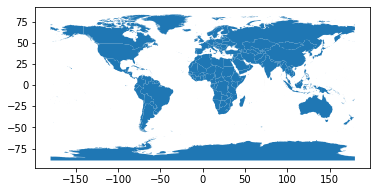

In [ ]:
worldmap.plot()

The "ISO" column in this table corresponds to the information in the "countryCode" column in our filtered species data table.

We can use the map data to check that each point in the species table is actually in the country it is reported as being in.

In order to allow Python to interpret geographical data, we need to convert our species dataframe into a "geodataframe".  This converts the points in the 'decimalLongitude' and 'decimalLatitude' columns into points on a map.

In order to convert latitude and longitude points into map points we used a map projection - https://en.wikipedia.org/wiki/Map_projection - the points can be converted in different ways depending on the map used.

Our species observation points and the country polygons are recorded in projection ESPG 4326 or the "Web Mercator" projection.


In [ ]:
# convert the table to geopandas
# tell Python that "decimalLongitude" and "decimalLatitude" are geographical points in the EPSG 4326 projection.
gdf = gpd.GeoDataFrame(mytab,
                       geometry=gpd.points_from_xy(mytab['decimalLongitude'], mytab['decimalLatitude']),
                       crs="epsg:4326")

The table now has a "geometry" column with the new information.

In [ ]:
gdf

,CountryName,countryCode,gbifID,datasetKey,occurrenceID,kingdom,phylum,class,order,family,genus,species,infraspecificEpithet,taxonRank,scientificName,verbatimScientificName,verbatimScientificNameAuthorship,locality,stateProvince,occurrenceStatus,individualCount,publishingOrgKey,decimalLatitude,decimalLongitude,coordinateUncertaintyInMeters,coordinatePrecision,elevation,elevationAccuracy,depth,depthAccuracy,eventDate,day,month,year,taxonKey,speciesKey,basisOfRecord,institutionCode,collectionCode,catalogNumber,recordNumber,identifiedBy,dateIdentified,license,rightsHolder,recordedBy,typeStatus,establishmentMeans,lastInterpreted,mediaType,issue,geometry
0,Austria,AT,2445054003,50c9509d-22c7-4a22-a47d-8c48425ef4a7,https://www.inaturalist.org/observations/34636624,Animalia,Arthropoda,Insecta,Hymenoptera,Tenthredinidae,Athalia,Athalia rosae,NaN,SPECIES,"Athalia rosae (Linnaeus, 1758)",Athalia rosae,NaN,NaN,Steiermark,NaN,NaN,28eb1a3f-1c15-4a95-931a-4af90ecb574d,46.735321,15.583444,NaN,NaN,NaN,NaN,NaN,NaN,2019-10-20T17:16:51,20.0,10.0,2019.0,4490913,4490913,HUMAN_OBSERVATION,iNaturalist,Observations,34636624,NaN,Alexander Boldyrev,NaN,CC_BY_NC_4_0,julia_neuer,julia_neuer,NaN,NaN,2020-07-21T08:52:00.522Z,StillImage,COORDINATE_ROUNDED;GEODETIC_DATUM_ASSUMED_WGS84,POINT (15.58344 46.73532)
1,Austria,AT,1949983717,50c9509d-22c7-4a22-a47d-8c48425ef4a7,https://www.inaturalist.org/observations/17679331,Animalia,Arthropoda,Insecta,Hymenoptera,Tenthredinidae,Athalia,Athalia rosae,NaN,SPECIES,"Athalia rosae (Linnaeus, 1758)",Athalia rosae,NaN,NaN,Wien,NaN,NaN,28eb1a3f-1c15-4a95-931a-4af90ecb574d,48.304750,16.419672,6.0,NaN,NaN,NaN,NaN,NaN,2018-10-20T09:55:10,20.0,10.0,2018.0,4490913,4490913,HUMAN_OBSERVATION,iNaturalist,Observations,17679331,NaN,carnifex,2018-10-20T16:19:41,CC_BY_NC_4_0,carnifex,carnifex,NaN,NaN,2020-07-21T08:51:34.566Z,StillImage,COORDINATE_ROUNDED;GEODETIC_DATUM_ASSUMED_WGS84,POINT (16.41967 48.30475)
2,Austria,AT,1946190437,50c9509d-22c7-4a22-a47d-8c48425ef4a7,https://www.inaturalist.org/observations/12173291,Animalia,Arthropoda,Insecta,Hymenoptera,Tenthredinidae,Athalia,Athalia rosae,NaN,SPECIES,"Athalia rosae (Linnaeus, 1758)",Athalia rosae,NaN,NaN,Wien,NaN,NaN,28eb1a3f-1c15-4a95-931a-4af90ecb574d,48.231321,16.333859,44.0,NaN,NaN,NaN,NaN,NaN,2018-05-05T23:01:42,5.0,5.0,2018.0,4490913,4490913,HUMAN_OBSERVATION,iNaturalist,Observations,12173291,NaN,Konstantin,2018-11-28T05:24:27,CC_BY_NC_4_0,carnifex,carnifex,NaN,NaN,2020-07-21T08:51:33.716Z,StillImage,GEODETIC_DATUM_ASSUMED_WGS84,POINT (16.33386 48.23132)
3,Austria,AT,1338113327,6ac3f774-d9fb-4796-b3e9-92bf6c81c084,NaN,Animalia,Arthropoda,Insecta,Hymenoptera,Tenthredinidae,Athalia,Athalia rosae,NaN,SPECIES,"Athalia rosae (Linnaeus, 1758)",Athalia rosae,NaN,"Schloss und Park Arenberg, Salzburg",NaN,NaN,NaN,bb646dff-a905-4403-a49b-6d378c2cf0d9,47.799248,13.058721,250.0,NaN,NaN,NaN,NaN,NaN,2014-09-12T00:00:00,12.0,9.0,2014.0,4490913,4490913,HUMAN_OBSERVATION,naturgucker,naturgucker,750179370,NaN,NaN,NaN,CC_BY_4_0,NaN,-1082328577,NaN,NaN,2020-03-01T11:56:29.324Z,NaN,COORDINATE_ROUNDED;GEODETIC_DATUM_ASSUMED_WGS84,POINT (13.05872 47.79925)
4,Belgium,BE,2283049884,50c9509d-22c7-4a22-a47d-8c48425ef4a7,https://www.inaturalist.org/observations/27806550,Animalia,Arthropoda,Insecta,Hymenoptera,Tenthredinidae,Athalia,Athalia rosae,NaN,SPECIES,"Athalia rosae (Linnaeus, 1758)",Athalia rosae,NaN,NaN,Wallonie,NaN,NaN,28eb1a3f-1c15-4a95-931a-4af90ecb574d,50.708869,4.779504,12.0,NaN,NaN,NaN,NaN,NaN,2019-06-28T15:10:00,28.0,6.0,2019.0,4490913,4490913,HUMAN_OBSERVATION,iNaturalist,Observations,27806550,NaN,Colin Ducarme,2019-06-28T13:17:05,CC_BY_NC_4_0,Colin Ducarme,Colin Ducarme,NaN,NaN,2020-07-21T08:51:37.022Z,StillImage,COORDINATE_ROUNDED;GEODETIC_DATUM_ASSUMED_WGS84,POINT (4.77950 50.70887)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

Converting both columns to a different projection - the "World Equidistant Cylindrical" or ESPG 4088 - just makes the images of the map look more familiar.  We also add a couple of extra columns to the table here with the x and y positions in this projection - just for convenience later.

In [ ]:
worldmap = worldmap.to_crs('epsg:4088')
gdf = gdf.to_crs('epsg:4088')

x_positions_cyl = [x.coords[0][0] for x in gdf['geometry']]
y_positions_cyl = [x.coords[0][1] for x in gdf['geometry']]
gdf['x_positions'] = x_positions_cyl
gdf['y_positions'] = y_positions_cyl

We can now plot the points on a map.

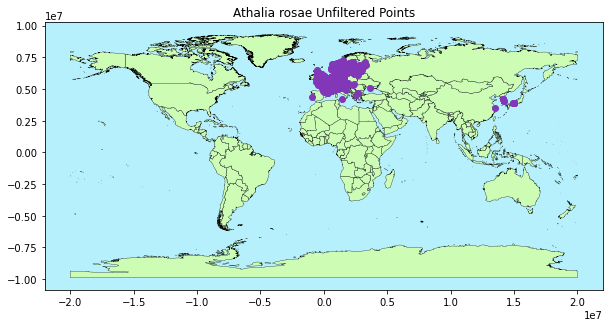

In [ ]:
# feel free to change these colours using the codes here: https://htmlcolorcodes.com/
sea_colour = '#B5F0FC'
land_colour = '#CDFCB5'
point_colour = '#8237B9'


# create an empty set of axis
f = plt.figure(figsize=(10, 10))

# add a plot to these axis
a = f.add_subplot(111, facecolor=sea_colour)

# plot the countries onto the axis
worldmap.plot(ax=a, color=land_colour, edgecolor='black', lw=0.3)

# add the species observation points
gdf['geometry'].plot(ax=a, color=point_colour)

# add a title
a.set_title(species_name.replace("_", " ") + " Unfiltered Points")

# save a copy
f.savefig(file_path + "/unfiltered_maps/" + species_name + ".png", dpi=300, bbox_inches='tight')

We want to check that each point has been recorded in the right country.

First, we record all the country polygons into a Python dictionary.  This code just links each country code to a polygon in the worldmap table.

In [ ]:
country_dict = dict()
for iso, polygon in zip(worldmap['ISO'], worldmap['geometry']):
  country_dict[iso] = polygon

In [ ]:
country_dict = dict(zip(worldmap['ISO'], worldmap['geometry']))

Each polygon can be accessed using the country code, e.g.

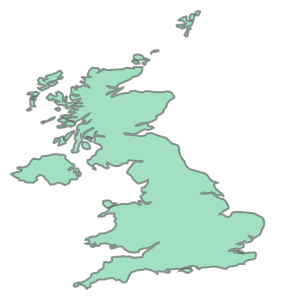

In [ ]:
country_dict['GB']

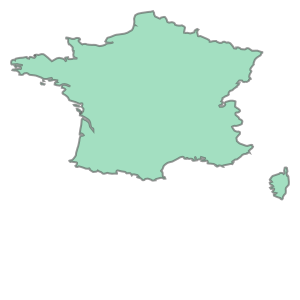

In [ ]:
country_dict['FR']

We can check one point manually just to demonstrate.

Take the last point in the table - point 2972 - which should be in the UK.


In [ ]:
# select point 2972
current_point = gdf.loc[2972]

Using the ```within``` function we can check if this point is within this region.

In [ ]:
current_point['geometry'].within(country_dict['GB'])

True

This prints "True" - the point is within the UK.  We can check on a map.

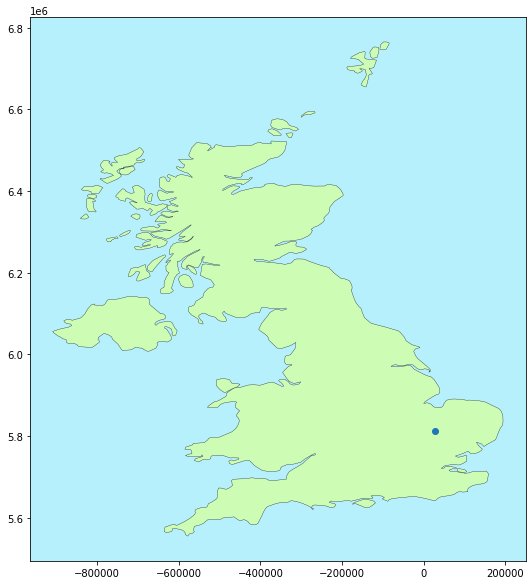

In [ ]:

# create an empty set of axis
f = plt.figure(figsize=(10, 10))

# add a plot to these axis
a = f.add_subplot(111, facecolor=sea_colour)

# select the UK only
uk_map = worldmap[worldmap['ISO'] == 'GB']
uk_map.plot(ax=a, color=land_colour, edgecolor='black', lw=0.3)

# plot the point on the map
a.scatter(current_point['x_positions'], current_point['y_positions'])

Now we can run through each point in the table and check it is in the right country.

In [ ]:
correct_country = []
# run through every point the table
for iso, point in zip(gdf['countryCode'], gdf['geometry']):
  # get the polygon the point should be inside
  poly = country_dict[iso]
  # check the point is in the polygon
  correct_country.append(point.within(poly))

# insert this information into the table
gdf['correct_country'] = correct_country

Now the "correct country" column in the table tells us if the point was recorded in the right country or not.

We want to save the incorrect countries in a separate table and count how many there are.

In [ ]:
wrong_country = gdf[gdf['correct_country'] == False]
wrong_country.to_csv(file_path + "/wrong_country_tables/"  + species_name + ".csv", sep="\t", index=None)

count_wrong_country = len(wrong_country)

gdf = gdf[gdf['correct_country'] == True]

geosummary.loc[species_name, "n_in_wrong_country"] = count_wrong_country

In [ ]:
geosummary

,nrecords_unfiltered,n_in_wrong_country,n_in_ocean,nrecords_clean
Athalia_rosae,2973,292,NaN,NaN


Next we want to look for points which are in the ocean - these are unlikely to be correct, especially as they are far from the coast.

We need to import a map projection from another package which provides a function to check this.

In [ ]:
# read in a map in the world cylindrical projection
m = Basemap(projection='cyl',
            llcrnrlat=-90,
            urcrnrlat=90,\
            llcrnrlon=-180,
            urcrnrlon=180,
            resolution='l')

The ```is_land``` function tells us if the point is on land.

e.g. if we take point 2732 again

In [ ]:
point = gdf.loc[2732]

m.is_land(point['decimalLongitude'], point['decimalLatitude'])

True

We need to run this for every point in the table.

In [ ]:
# make a list to store the results
results = []
for long, lat in zip(gdf['decimalLongitude'], gdf['decimalLatitude']):
  # check if the point is on land
  point_is_land = m.is_land(long, lat)
  results.append(point_is_land)

# put this data into the table
gdf['is_land'] = results

In [ ]:
gdf

,CountryName,countryCode,gbifID,datasetKey,occurrenceID,kingdom,phylum,class,order,family,genus,species,infraspecificEpithet,taxonRank,scientificName,verbatimScientificName,verbatimScientificNameAuthorship,locality,stateProvince,occurrenceStatus,individualCount,publishingOrgKey,decimalLatitude,decimalLongitude,coordinateUncertaintyInMeters,coordinatePrecision,elevation,elevationAccuracy,depth,depthAccuracy,eventDate,day,month,year,taxonKey,speciesKey,basisOfRecord,institutionCode,collectionCode,catalogNumber,recordNumber,identifiedBy,dateIdentified,license,rightsHolder,recordedBy,typeStatus,establishmentMeans,lastInterpreted,mediaType,issue,geometry,x_positions,y_positions,correct_country,is_land
0,Austria,AT,2445054003,50c9509d-22c7-4a22-a47d-8c48425ef4a7,https://www.inaturalist.org/observations/34636624,Animalia,Arthropoda,Insecta,Hymenoptera,Tenthredinidae,Athalia,Athalia rosae,NaN,SPECIES,"Athalia rosae (Linnaeus, 1758)",Athalia rosae,NaN,NaN,Steiermark,NaN,NaN,28eb1a3f-1c15-4a95-931a-4af90ecb574d,46.735321,15.583444,NaN,NaN,NaN,NaN,NaN,NaN,2019-10-20T17:16:51,20.0,10.0,2019.0,4490913,4490913,HUMAN_OBSERVATION,iNaturalist,Observations,34636624,NaN,Alexander Boldyrev,NaN,CC_BY_NC_4_0,julia_neuer,julia_neuer,NaN,NaN,2020-07-21T08:52:00.522Z,StillImage,COORDINATE_ROUNDED;GEODETIC_DATUM_ASSUMED_WGS84,POINT (1732801.816 5196736.300),1.732802e+06,5.196736e+06,True,True
1,Austria,AT,1949983717,50c9509d-22c7-4a22-a47d-8c48425ef4a7,https://www.inaturalist.org/observations/17679331,Animalia,Arthropoda,Insecta,Hymenoptera,Tenthredinidae,Athalia,Athalia rosae,NaN,SPECIES,"Athalia rosae (Linnaeus, 1758)",Athalia rosae,NaN,NaN,Wien,NaN,NaN,28eb1a3f-1c15-4a95-931a-4af90ecb574d,48.304750,16.419672,6.0,NaN,NaN,NaN,NaN,NaN,2018-10-20T09:55:10,20.0,10.0,2018.0,4490913,4490913,HUMAN_OBSERVATION,iNaturalist,Observations,17679331,NaN,carnifex,2018-10-20T16:19:41,CC_BY_NC_4_0,carnifex,carnifex,NaN,NaN,2020-07-21T08:51:34.566Z,StillImage,COORDINATE_ROUNDED;GEODETIC_DATUM_ASSUMED_WGS84,POINT (1825786.230 5371249.034),1.825786e+06,5.371249e+06,True,True
2,Austria,AT,1946190437,50c9509d-22c7-4a22-a47d-8c48425ef4a7,https://www.inaturalist.org/observations/12173291,Animalia,Arthropoda,Insecta,Hymenoptera,Tenthredinidae,Athalia,Athalia rosae,NaN,SPECIES,"Athalia rosae (Linnaeus, 1758)",Athalia rosae,NaN,NaN,Wien,NaN,NaN,28eb1a3f-1c15-4a95-931a-4af90ecb574d,48.231321,16.333859,44.0,NaN,NaN,NaN,NaN,NaN,2018-05-05T23:01:42,5.0,5.0,2018.0,4490913,4490913,HUMAN_OBSERVATION,iNaturalist,Observations,12173291,NaN,Konstantin,2018-11-28T05:24:27,CC_BY_NC_4_0,carnifex,carnifex,NaN,NaN,2020-07-21T08:51:33.716Z,StillImage,GEODETIC_DATUM_ASSUMED_WGS84,POINT (1816244.249 5363084.093),1.816244e+06,5.363084e+06,True,True
3,Austria,AT,1338113327,6ac3f774-d9fb-4796-b3e9-92bf6c81c084,NaN,Animalia,Arthropoda,Insecta,Hymenoptera,Tenthredinidae,Athalia,Athalia rosae,NaN,SPECIES,"Athalia rosae (Linnaeus, 1758)",Athalia rosae,NaN,"Schloss und Park Arenberg, Salzburg",NaN,NaN,NaN,bb646dff-a905-4403-a49b-6d378c2cf0d9,47.799248,13.058721,250.0,NaN,NaN,NaN,NaN,NaN,2014-09-12T00:00:00,12.0,9.0,2014.0,4490913,4490913,HUMAN_OBSERVATION,naturgucker,naturgucker,750179370,NaN,NaN,NaN,CC_BY_4_0,NaN,-1082328577,NaN,NaN,2020-03-01T11:56:29.324Z,NaN,COORDINATE_ROUNDED;GEODETIC_DATUM_ASSUMED_WGS84,POINT (1452065.119 5315039.715),1.452065e+06,5.315040e+06,True,True
4,Belgium,BE,2283049884,50c9509d-22c7-4a22-a47d-8c48425ef4a7,https://www.inaturalist.org/observations/27806550,Animalia,Arthropoda,Insecta,Hymenoptera,Tenthredinidae,Athalia,Athalia rosae,NaN,SPECIES,"Athalia rosae (Linnaeus, 1758)",Athalia rosae,NaN,NaN,Wallonie,NaN,NaN,28eb1a3f-1c15-4a95-931a-4af90ecb574d,50.708869,4.779504,12.0,NaN,NaN,NaN,NaN,NaN,2019-06-28T15:10:00,28.0,6.0,2019.0,4490913,4490913,HUMAN_OBSERVATION,iNaturalist,Observations,27806550,NaN,Colin Ducarme,2019-06-28T13:17:05,CC_BY_NC_4_0,Colin Ducarme,Colin Ducarme,NaN,NaN,2020-07-21T08:51:37.022Z,StillImage,COORDINATE_ROUNDED;GEODETIC_DATUM_ASSUMED_WGS84,POINT (5314

Now we can move the "sea" points into a seperate table and filter them out of the main table.



In [ ]:
gdf_sea = gdf[gdf['is_land'] == False]
geosummary.loc[species_name, 'n_in_ocean'] = len(gdf_sea)
gdf = gdf[gdf['is_land'] == True]

Now we've finished filtering the table, we can make another plot with just the good quality points.

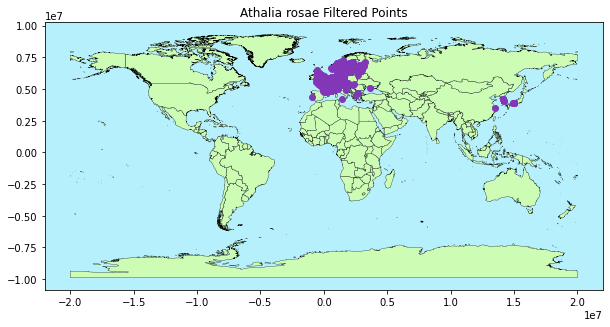

In [ ]:
# feel free to change these colours using the codes here: https://htmlcolorcodes.com/
sea_colour = '#B5F0FC'
land_colour = '#CDFCB5'
point_colour = '#8237B9'


# create an empty set of axis
f = plt.figure(figsize=(10, 10))

# add a plot to these axis
a = f.add_subplot(111, facecolor=sea_colour)

# plot the countries onto the axis
worldmap.plot(ax=a, color=land_colour, edgecolor='black', lw=0.3)

# add the species observation points
gdf['geometry'].plot(ax=a, color=point_colour)

# add a title
a.set_title(species_name.replace("_", " ") + " Filtered Points")

# save a copy
f.savefig(file_path + "/filtered_maps/" + species_name + ".png", dpi=300, bbox_inches='tight')

We also want to record the remaining number of points in the summary table.

In [ ]:
geosummary.loc[species_name, 'nrecords_clean'] = len(gdf)

In [ ]:
geosummary

,nrecords_unfiltered,n_in_wrong_country,n_in_ocean,nrecords_clean
Athalia_rosae,2973,292,188,2493


Finally, we save the clean table and the summary table.

In [ ]:
gdf.to_csv(file_path + "/geo_filtered_main_tables/" + species_name + ".csv", sep="\t", index=None)
geosummary.to_csv(file_path + "/geo_summary_tables/" + species_name + ".csv", sep="\t")